In [7]:
import hmc_tomography
import numpy, scipy
import matplotlib.pyplot as plt

numpy.set_printoptions(precision=2, suppress=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Tutorial 6 - Medical imaging using straight ray tomography, exotic priors and HMC

<div class="alert alert-warning">
    
<b>**WARNING**:</b> The system requirements of running this notebook exceed typical personal workstations at the time of writing. Especially loading the entire forward model into memory as well as the resulting Monte Carlo samples requires at least <b>32GB of RAM</b>.
</div>

<div class="alert alert-info">
<b>Note:</b> Throughout this notebook, we'll sample various distributions. Tuning settings are updated accordingly, but not discussed. Keep this in mind when playing around with the notebook; you might need to update parameters, primarily step lengths.
</div>

## Act 0: Loading the data, defining the noise

We will first define the model and data space size. Model parameters and data in linear forward problems are related with the following equation:


$$
\mathbf{d} = G\mathbf{m}
$$


Here, $\mathbf{d}$ and $\mathbf{m}$ are column vectors of resp. shape $[d \times 1]$ and $[m \times 1]$, and G has size $[m \times d]$. We get these models and quantities from our domain experts, **in this case, Ines!**

Here we load these (huge!) beasts from disk. I already converted them to floats of size 32, to accelerate computation and minimize memory usage.

In [2]:
G = scipy.sparse.load_npz("medical_imaging_files/G_float32.npz")

dpoints, dimensions = G.shape

d_obs = numpy.load("medical_imaging_files/TravelTimeShifts.npy").astype("float32")
d_obs.shape = (d_obs.size, 1)

print(
    "Forward model:\n\n",
    G.todense(),
    "\n\ntype:",
    type(G),
    "\n\ndtype:",
    G.dtype,
    "\n\nshape:",
    G.shape,
    "\n\n\n\n",
)

print(
    "Data:\n\n",
    d_obs,
    "\n\ntype:",
    type(d_obs),
    "\n\ndtype:",
    d_obs.dtype,
    "\n\nshape:",
    d_obs.shape,
    "\n\n",
)

Forward model:

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

type: <class 'scipy.sparse.csr.csr_matrix'> 

dtype: float32 

shape: (64495, 50625) 




Data:

 [[-0.]
 [-0.]
 [-0.]
 ...
 [-0.]
 [-0.]
 [-0.]] 

type: <class 'numpy.ndarray'> 

dtype: float32 

shape: (64495, 1) 




Next we inspect the data, to get a feeling of the size of datums.

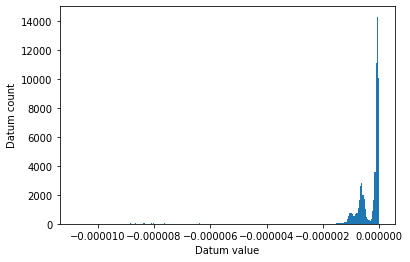

In [3]:
plt.hist(d_obs, bins=int(d_obs.size**0.5))
plt.ylabel("Datum count")
plt.xlabel("Datum value")
plt.show()

We assume the observed data is controlled by the true medium, and observational uncertainties in the following way:

$$
\mathbf{d}_\text{obs} = G\mathbf{m}_\text{true} + \mathbf{\sigma}
$$

Note that the added noise $\sigma$ is also a vector. We typically assume it's normally distributed (using a multivariate Gaussian):

$$
\mathbf{\sigma} \sim \mathcal{N} (\mathbf{0} , \Sigma)
$$

which makes inference in general much easier.

The description of the noise may depend strongly on which datapoint we look at. There could be correlations and strong differences in standard deviation for each datum $d_i$, as captured in the covariance matrix $\Sigma$. We will first start with a diagonal (non-correlated) data covariance matrix. 

Now we have everything we need to define our (non-regularized / prior-less) inference problem using a provided class. This object analyses the supplied objects and determines the appropriate methods (i.e. sparse vs dense $G$, dense vs diagonal $\Sigma$, etc.).

In [20]:
# Assumed data noise standard deviation
std = 1e-6

# Diagonal of the covariance matrix
data_var = (std**2) * numpy.ones((dpoints,1)) 

# Likelihood from these objects, incorporating the model, the observations and the noise model.
likelihood = hmc_tomography.Distributions.LinearMatrix(
    G, d_obs, data_var, premultiplication=False, use_mkl=True
)

## Act 1: The Multivariate Normal distribution as a prior on the parameters.

One of the most common (**and useful**) priors in inference is the multivariate normal distribution. This prior creates a normal distribution on every separate parameter with optional correlations between the parameters. In this way, we can dampen the parameters *towards* the mean of the multivariate normal. The variance indicates the strength of damping.

In [21]:
prior_means = numpy.zeros((likelihood.dimensions,1))
prior_variances = 1e-6* numpy.ones((likelihood.dimensions,1))
prior = hmc_tomography.Distributions.Normal(prior_means, prior_variances)

/home/lgebraad/hmc-tomography framework/hmc_tomography/Distributions/base.py:330: Warning: Seems that you only passed a vector as the covariance matrix. It will be used as the covariance diagonal.
  Warning,


Use Bayes' rule:

In [22]:
posterior = hmc_tomography.Distributions.BayesRule([prior, likelihood])

Perform a gradient descent on the resulting posterior:

In [23]:
optimizer = hmc_tomography.Optimizers.gradient_descent(posterior)
m, dm_list, misfits = optimizer.iterate(numpy.zeros((dimensions,1)), epsilon=1e-11, nmax=10)

Visualize the result:

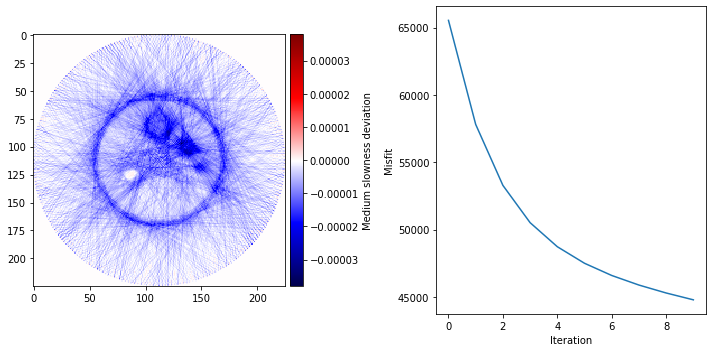

In [24]:
extremum = numpy.abs(m).max()

figure, axes = plt.subplots(1,2, figsize=(10,5))
image = axes[0].imshow(numpy.reshape(m, (int(m.size**0.5),int(m.size**0.5))  ), vmin=-extremum, vmax=extremum, cmap=plt.get_cmap("seismic"))

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.075)
figure.colorbar(image, cax=cax, orientation='vertical')
cax.set_ylabel("Medium slowness deviation")

axes[1].plot(misfits)
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Misfit")
figure.tight_layout()

Looking pretty slick already! On the right, we have the misfit curve as we are descending.

## Act 2: using a Laplace distribution as a prior

Another interesting prior is the Laplace distribution. Putting this prior on something basically minimizes the amount of parameters that are non-zero, i.e. promotes sparsity. Let's define it:

In [25]:
prior_means = numpy.zeros((likelihood.dimensions,1))
prior_variances = 1e-5 * numpy.ones((likelihood.dimensions,1))
prior = hmc_tomography.Distributions.Laplace(prior_means, prior_variances)

And use Bayes' rule:

In [26]:
posterior = hmc_tomography.Distributions.BayesRule([prior, likelihood])

Gradient descent:

In [27]:
optimizer = hmc_tomography.Optimizers.gradient_descent(posterior)
result_laplace, dm_list, misfits = optimizer.iterate(numpy.zeros((dimensions,1)), 
                                                     epsilon=1e-11, nmax=10)

And visualize:

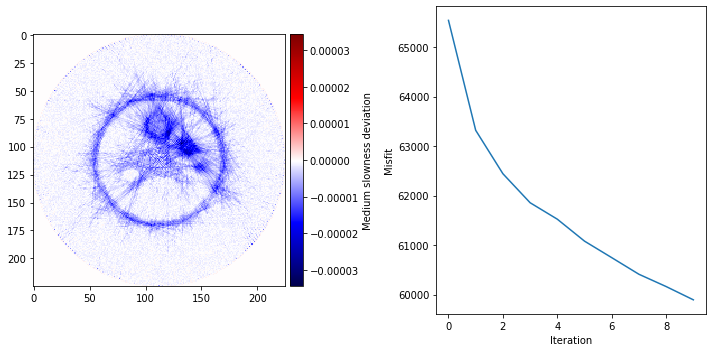

In [28]:
extremum = numpy.abs(result_laplace).max()

figure, axes = plt.subplots(1,2, figsize=(10,5))
image = axes[0].imshow(numpy.reshape(result_laplace, (int(result_laplace.size**0.5),int(result_laplace.size**0.5))  ), vmin=-extremum, vmax=extremum, cmap=plt.get_cmap("seismic"))

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.075)
figure.colorbar(image, cax=cax, orientation='vertical')
cax.set_ylabel("Medium slowness deviation")

axes[1].plot(misfits)
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Misfit")
figure.tight_layout()

Looking better already, but there still seems to be a lot of noise and variability in the recovery. Maybe we can inject our expectation that the target is smooth in addition to the expectation the the target is sparse?

## Act 3: Combining priors

To encode the smoothness expectation on the target, I create a Gaussian on the discrete Laplacian of every realization. This sounds complicated. Maybe it is, but intuitively it is not too hard:

1. Compute a discrete Laplacian using a finite difference stencil.
2. Require this Laplacian, a measure of smoothness, to be close to zero.

This way, rough models are penalized.

In the following cell I construct the operator for the smooth Laplacian:

In [176]:
field = scipy.sparse.csr_matrix((int(m.size**0.5),int(m.size**0.5)))

operator = scipy.sparse.lil_matrix((field.shape[0]*field.shape[1],field.shape[0]*field.shape[1]), dtype='float32')

from tqdm import trange

for i in trange(field.shape[0]):
    for j in range(field.shape[1]):
        index = i * int(field.shape[0]) + j
        operator[index, index] = -8
        
        if not i-1 == -1:
            index_alt = (i-1) * int(field.shape[0]) + j
            operator[index_alt, index] = 1
        
        if not i+1 == field.shape[0]:
            index_alt = (i+1) * int(field.shape[0]) + j
            operator[index_alt, index] = 1
        
        if not j-1 == -1:
            index_alt = i * int(field.shape[0]) + (j-1)
            operator[index_alt, index] = 1
        
        if not j+1 == field.shape[1]:
            index_alt = i * int(field.shape[0]) + (j+1)
            operator[index_alt, index] = 1
            
        if not i+1 == field.shape[0] and not j+1 == field.shape[1]:
            index_alt = (i+1) * int(field.shape[0]) + (j+1)
            operator[index_alt, index] = 1
            
        if not i-1 == -1 and not j-1 == -1:
            index_alt = (i-1) * int(field.shape[0]) + (j-1)
            operator[index_alt, index] = 1
                    
        if not i-1 == -1 and not j+1 == field.shape[1]:
            index_alt = (i-1) * int(field.shape[0]) + (j+1)
            operator[index_alt, index] = 1
            
        if not i+1 == field.shape[0] and not j-1 == -1:
            index_alt = (i+1) * int(field.shape[0]) + (j-1)
            operator[index_alt, index] = 1

100%|██████████| 225/225 [00:01<00:00, 119.04it/s]


Create the distribution on this operator:

In [177]:
smoother_var = 1e-9 * numpy.ones((dimensions, 1))

smoother = hmc_tomography.Distributions.LinearMatrix(
    operator, numpy.zeros((dimensions,1)), smoother_var, premultiplication=False
)

Create the Laplace distribution:

In [178]:
prior_means = numpy.zeros((likelihood.dimensions,1))
prior_variances = 1e-5 * numpy.ones((likelihood.dimensions,1))
prior = hmc_tomography.Distributions.Laplace(prior_means, prior_variances)

Use Bayes' rule:

In [179]:
posterior = hmc_tomography.Distributions.BayesRule([prior, likelihood, smoother])

Descent on the posterior:

In [182]:
optimizer = hmc_tomography.Optimizers.gradient_descent(posterior)
m, dm_list, misfits = optimizer.iterate(result_laplace, epsilon=.25e-11, nmax=30)
descent_final = m

And visualize:

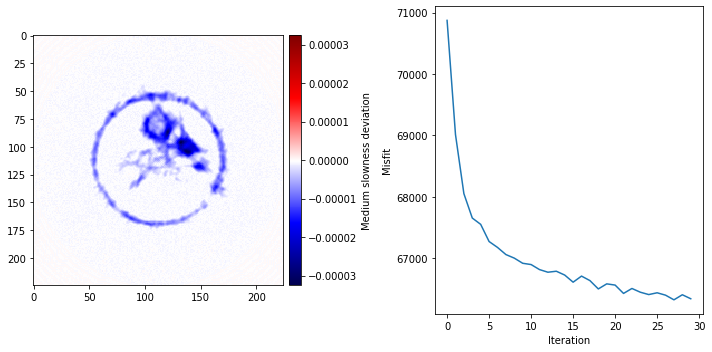

In [183]:
extremum = numpy.abs(m).max()

figure, axes = plt.subplots(1,2, figsize=(10,5))
image = axes[0].imshow(numpy.reshape(m, (int(m.size**0.5),int(m.size**0.5))  ), vmin=-extremum, vmax=extremum, cmap=plt.get_cmap("seismic"))

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.075)
figure.colorbar(image, cax=cax, orientation='vertical')
cax.set_ylabel("Medium slowness deviation")

axes[1].plot(misfits)
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Misfit")
figure.tight_layout()

This looks like a pretty nice posterior. Let's sample it! 

To cheat a little, let's start at our last model:

In [184]:
markov_chain_starting_model = descent_final

**Let's start sampling!**

In [185]:
# Create a sampler
hmc_sampler = hmc_tomography.Samplers.HMC()

mm = hmc_tomography.MassMatrices.Unit(posterior.dimensions)

hmc_sampler.sample(
    posterior,
    mm,
    "bin_samples/initial_sampling.h5",
    proposals=200,
    integration_steps=20,
    time_step=0.0000001,
    online_thinning=1,
    overwrite_samples=False,
    initial_model=markov_chain_starting_model,
)

Let's now compute the same quantities using the samples. The `with` construct is essential, as it closes the sample file after we exit the indent. This ensures that we don't leave open the HDF5 file. **Additionally, we'll visualize the 1d and 2d marginals of the posterior.**

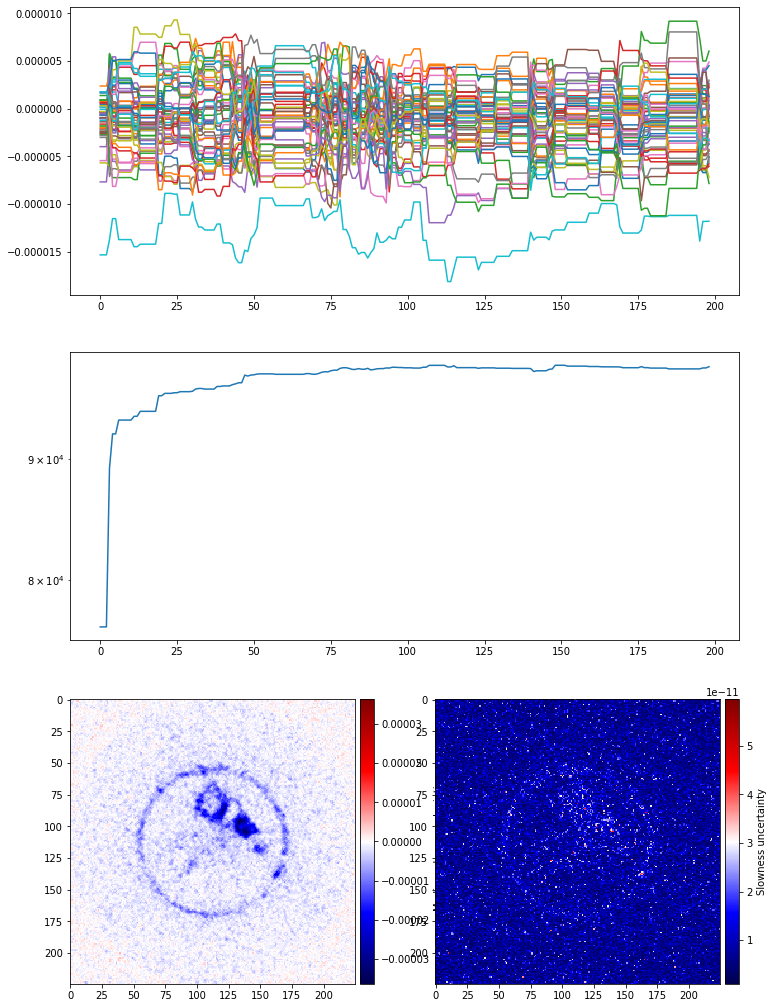

In [186]:
with hmc_tomography.Post.Samples("bin_samples/initial_sampling.h5", burn_in=0) as samples:

    plt.figure(figsize=(12,18))
    plt.subplot(311)
    plt.plot(samples.raw_samples[::1000,:].T)
    plt.subplot(312)
    plt.semilogy(samples.raw_samples[-1,:])
    
    last_sample_from_burn_in = samples.raw_samples[:,-1]
    
    plt.subplot(325)
    
    m = samples.raw_samples[:-1,:].mean(axis=1)

    extremum = numpy.abs(m).max()
    
    image = plt.imshow(numpy.reshape(m, (int(m.size**0.5),int(m.size**0.5))  ), vmin=-extremum, vmax=extremum, cmap=plt.get_cmap("seismic"))

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.075)
    figure.colorbar(image, cax=cax, orientation='vertical')
    cax.set_ylabel("Medium slowness deviation")    
    
    plt.subplot(326)
    
    m = samples.raw_samples[:-1,:].var(axis=1)
    
    mass_matrix_diagonal = 1.0/m
    
    image = plt.imshow(numpy.reshape(m, (int(m.size**0.5),int(m.size**0.5))  ), cmap=plt.get_cmap("seismic"))

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.075)
    figure.colorbar(image, cax=cax, orientation='vertical')
    cax.set_ylabel("Slowness uncertainty")

Looking good! Let's recycle the burn-in covariance to precondition HMC, i.e. we integrate the observed variability to accelerate sampling.

In [187]:
mm_diag = hmc_tomography.MassMatrices.Diagonal(posterior.dimensions, mass_matrix_diagonal[:,None])

print(last_sample_from_burn_in[:-1,None].shape)

hmc_sampler.sample(
    posterior,
    mm_diag,
    "bin_samples/second_phase.h5",
    proposals=1000,
    integration_steps=20,
    time_step=0.01,
    online_thinning=1,
    overwrite_samples=False,
    initial_model=last_sample_from_burn_in[:-1,None],
)

(50625, 1)


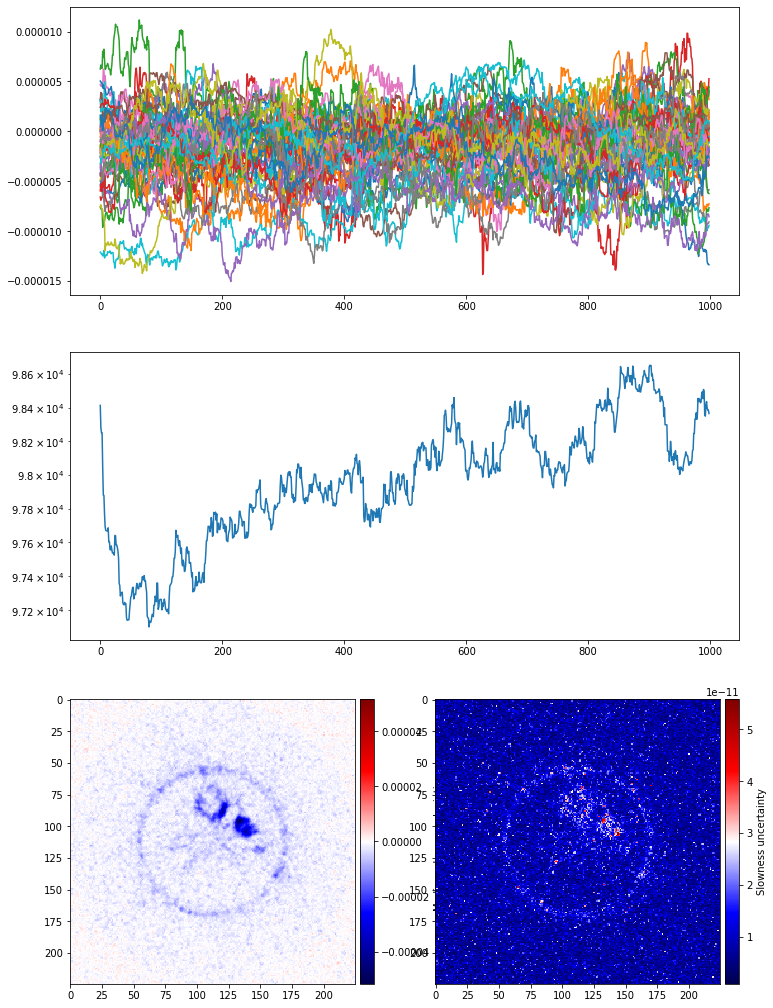

In [188]:
with hmc_tomography.Post.Samples("bin_samples/second_phase.h5", burn_in=0) as samples:

    plt.figure(figsize=(12,18))
    plt.subplot(311)
    plt.plot(samples.raw_samples[::1000,:].T)
    plt.subplot(312)
    plt.semilogy(samples.raw_samples[-1,:])
    
    last_sample_from_phase_2 = samples.raw_samples[:,-1]
    
    plt.subplot(325)
    
    m = samples.raw_samples[:-1,:].mean(axis=1)

    extremum = numpy.abs(m).max()
    
    image = plt.imshow(numpy.reshape(m, (int(m.size**0.5),int(m.size**0.5))  ), vmin=-extremum, vmax=extremum, cmap=plt.get_cmap("seismic"))

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.075)
    figure.colorbar(image, cax=cax, orientation='vertical')
    cax.set_ylabel("Medium slowness deviation")    
    
    plt.subplot(326)
    
    m = samples.raw_samples[:-1,:].var(axis=1)
    
    mass_matrix_diagonal_phase_2 = 1.0/m
    
    image = plt.imshow(numpy.reshape(m, (int(m.size**0.5),int(m.size**0.5))  ), cmap=plt.get_cmap("seismic"))

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.075)
    figure.colorbar(image, cax=cax, orientation='vertical')
    cax.set_ylabel("Slowness uncertainty")

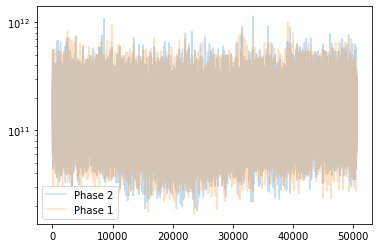

In [189]:
plt.semilogy(mass_matrix_diagonal_phase_2, label="Phase 2", alpha=0.25)
plt.semilogy(mass_matrix_diagonal, label="Phase 1", alpha=0.25)
plt.legend()

In [ ]:
mm_diag_phase_2 = hmc_tomography.MassMatrices.Diagonal(posterior.dimensions, mass_matrix_diagonal_phase_2[:,None])

print(last_sample_from_phase_2[:-1,None].shape)

hmc_sampler.sample(
    posterior,
    mm_diag_phase_2,
    "bin_samples/third_phase.h5",
    proposals=10000,
    integration_steps=100,
    time_step=0.015,
    online_thinning=1,
    overwrite_samples=False,
    initial_model=last_sample_from_phase_2[:-1,None],
)

sys:1: Warning: 
It seems that the samples file (bin_samples/third_phase_stronger_laplace.h5) already exists.


(50625, 1)
(n)ew file name, (o)verwrite or (a)bort? >> o


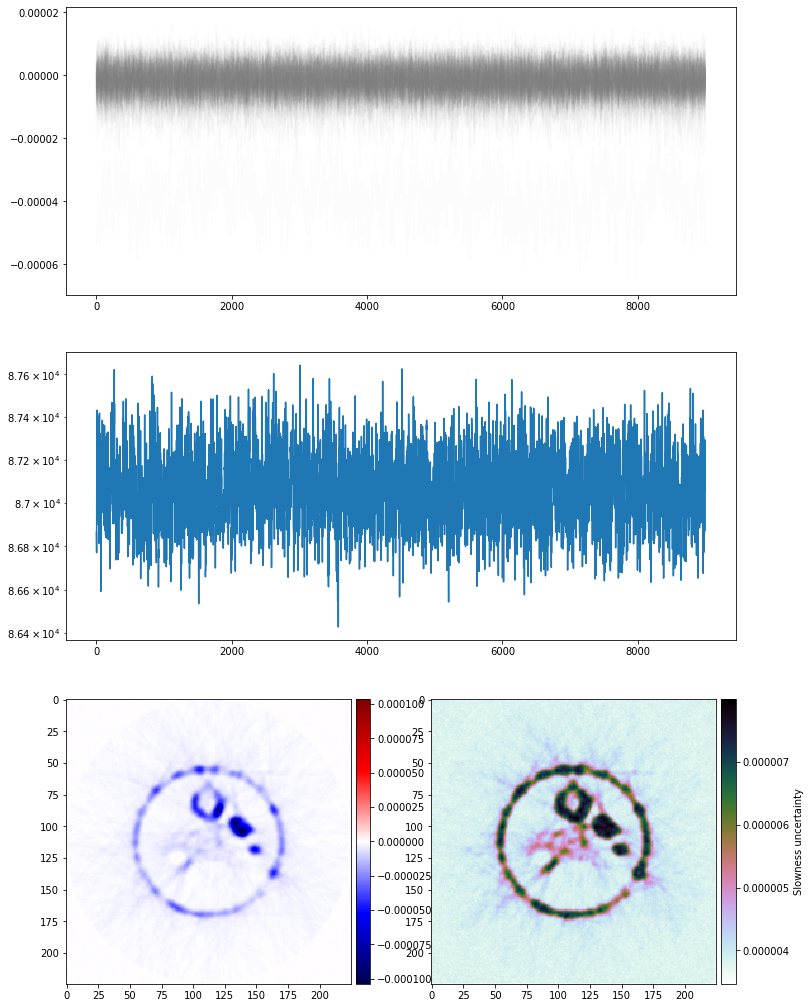

In [193]:
with hmc_tomography.Post.Samples("bin_samples/third_phase.h5", burn_in=1000) as samples:

    plt.figure(figsize=(12,18))
    plt.subplot(311)
    plt.plot(samples[::1000,:].T, 'k', alpha=0.01)
    plt.subplot(312)
    plt.semilogy(samples[-1,:])

    plt.subplot(325)
    
    m = samples[:-1,:].mean(axis=1)

    extremum = numpy.abs(m).max()
    
    image = plt.imshow(numpy.reshape(m, (int(m.size**0.5),int(m.size**0.5))  ), vmin=-extremum, vmax=extremum, cmap=plt.get_cmap("seismic"))

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.075)
    figure.colorbar(image, cax=cax, orientation='vertical')
    cax.set_ylabel("Medium slowness deviation")    
    
    plt.subplot(326)
    
    m = samples.raw_samples[:-1,:].std(axis=1)
    
#     extremum = numpy.max(numpy.abs(m))
    
    image = plt.imshow(numpy.reshape(m, (int(m.size**0.5),int(m.size**0.5))  ), cmap=plt.get_cmap("cubehelix_r"))

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.075)
    figure.colorbar(image, cax=cax, orientation='vertical')
    cax.set_ylabel("Slowness uncertainty")

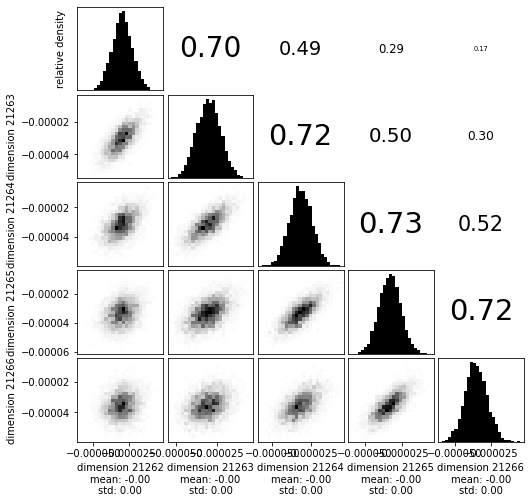

In [195]:
with hmc_tomography.Post.Samples("bin_samples/third_phase.h5", burn_in=1000) as samples:
    stds = samples[:-1,:].std(axis=1)
    index = numpy.argmax(stds)
    
    dims = [index-2, index-1, index, index+1, index+2]
    hmc_tomography.Post.Visualization.marginal_grid(samples, dimensions_list=dims)

When we investigate correlations between parameters, we can interpret these as resolution or point spread functions of the relevant parameters. We first calculate all the correlations in the posterior (which can take a while):

In [ ]:
with hmc_tomography.Post.Samples("bin_samples/third_phase.h5", burn_in=0) as samples:

    cors = numpy.corrcoef(samples[:-1,:], rowvar=True)

Now, extracting the correlations for one parameter and plotting these in the model gives us the PSF's.

NameError: name 'cors' is not defined

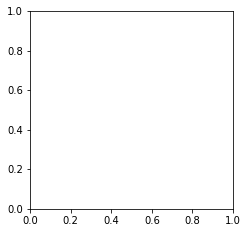

In [6]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(
    numpy.reshape(cors[index-225*48,:], (int(cors.shape[0]**0.5),int(cors.shape[0]**0.5))),
    vmin=-1,vmax=1, cmap=plt.get_cmap("seismic"))

plt.subplot(222)
plt.imshow(
    numpy.reshape(cors[index-225*41,:], (int(cors.shape[0]**0.5),int(cors.shape[0]**0.5))),
    vmin=-1,vmax=1, cmap=plt.get_cmap("seismic"))

plt.subplot(223)
plt.imshow(
    numpy.reshape(cors[index-225*35,:], (int(cors.shape[0]**0.5),int(cors.shape[0]**0.5))),
    vmin=-1,vmax=1, cmap=plt.get_cmap("seismic"))

plt.subplot(224)
plt.imshow(
    numpy.reshape(cors[index,:], (int(cors.shape[0]**0.5),int(cors.shape[0]**0.5))),
    vmin=-1,vmax=1, cmap=plt.get_cmap("seismic"))
plt.show()